# Import preprocessed data
## Preamble

In [1]:
from tqdm import tqdm
import numpy as np
from src.structures import User, Movie
from src.data_methods import read_movies,read_viewers
import kagglehub
import os

# Data downloading and preprocessing

In [2]:
# Download latest version
#please ikke offentliggør min api key. 
os.environ['KAGGLE_USERNAME'] = "marcusgaleajacobsen"
os.environ['KAGGLE_KEY'] = "32a3003f52c97053841ea46c492128dc"
datapath = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

In [3]:
n_lines = np.inf #number of reviews to read
datafiles = ["combined_data_1.txt"]#, "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"]
with_tqdm = True #set to True to see progress bar (reduce speed)
reviews_pr_user = 10 #number of reviews per user to read

movies = read_movies(datapath)
users = read_viewers(datapath, movies, datafiles = datafiles, with_tqdm= with_tqdm, n_lines=n_lines,)# reviews_pr_user=reviews_pr_user) #read only 100000 

100%|██████████| 24058263/24058263 [01:19<00:00, 302309.69it/s]


In [4]:
#trim users with less than 10 movies
not_enough_movies = [id for id,user in users.items() if user.n_watched < 200]
for user_id in not_enough_movies:
    del users[user_id]

# Compute minhash signatures
The following code computes the minhash signatures for the preprocessed data. The minhash signatures are computed using `mm3` hash functions. The signatures are stored in a dictionary where the key is the user id and the value is the minhash signature.

```python
SIG = {  
    "userid_1" : minhash_signature_1,
    "userid_2" : minhash_signature_2,
    ...
    "userid_n" : minhash_signature_n
    }
```

In [ ]:
from src.similarity_methods import compute_signatures, create_buckets, get_candidates, trim_candidates
n_hashes = 20 #number of hash functions
SIG = compute_signatures(users, n_hashes, with_tqdm = True)

100%|██████████| 21045/21045 [00:45<00:00, 461.32it/s]


# Locality Sensitive Hashing (LSH)
The following code splits the minhash signatures into bands of equals size. Each band for a user is hashed to a bucket id. The buckets are stored into a list of dictionaries where the key is the bucket id and the value is a list of user ids.

```python
buckets = [
    {
        "bucket_id_1" : ["userid_1", "userid_2", ...],
        "bucket_id_2" : ["userid_3", "userid_4", ...],
        ...
        "bucket_id_n" : ["userid_m", "userid_o", ...]
    },
    ...
    {
        "bucket_id_1" : ["userid_1", "userid_2", ...],
        "bucket_id_2" : ["userid_3", "userid_4", ...],
        ...
        "bucket_id_n" : ["userid_m", "userid_o", ...]
    }
]
```

In [ ]:
b = 5 #number of bands
n_buckets = 2**16
buckets = create_buckets(SIG, bands = b, n_buckets= n_buckets)

Compute the candidate pairs by comparing the users in the same bucket. The candidate pairs are stored in a list of tuples where the first element is the user id and the second element is the user id.

```python
candidate_pairs = [
    ("userid_1", "userid_2"),
    ("userid_3", "userid_4"),
    ...
    ("userid_m", "userid_o")
]
```

In [10]:
candidates = get_candidates(buckets)

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


Get measures for future performance evaluation.

In [ ]:
#binomial coefficient
from math import comb
n_candidates = len(candidates) #number of candidate pairs
n_users = len(users) #number of users
n_pairs = comb(n_users, 2) #number of possible pairs
n_pairs

221435490

In [ ]:
r = n_hashes // b #number of rows
t = (1/b)**(1/r) #threshold for similarity computed from number of bands and rows
t #threshold for similarity

0.668740304976422

In [ ]:
n_removed = trim_candidates(users, candidates, threshold = t)
print(f"Removed {n_removed} from {len(candidates)} candidates")

100%|██████████| 3109415/3109415 [04:30<00:00, 11503.93it/s]

Removed 143 from 3109415 candidates


In [15]:
for i,user in enumerate(users.values()):
    #only the first 10 users
    if i < 10:
        print(f"User {user.id} has neighbors {user.neighbors}")

User 1488844 has neighbors defaultdict(<class 'float'>, {'676450': 0.7863924050632911, '524619': 0.7894736842105263, '1815129': 0.7807660961695192, '2579439': 0.8066666666666666, '1906026': 0.8251273344651953, '441361': 0.7840909090909091, '327874': 0.7802768166089965, '1951711': 0.757328990228013, '1145636': 0.7732919254658385, '1578405': 0.7772511848341233, '1213065': 0.733890214797136, '442234': 0.7495309568480301, '225972': 0.7897793263646922, '1364878': 0.8072009291521487, '2069473': 0.717948717948718, '2051135': 0.7282415630550622, '2494753': 0.8093126385809313, '2327743': 0.7685250529287226, '501823': 0.675603217158177, '1645535': 0.7567567567567568, '1178332': 0.7564234326824255, '2580353': 0.7745614035087719, '1145387': 0.7647058823529411, '1823920': 0.7538126361655774, '2038137': 0.7749077490774908, '200805': 0.8161120840630472, '874732': 0.723943661971831, '1927703': 0.7161290322580646, '1010964': 0.7025813692480359, '1878548': 0.7213261648745519, '1787323': 0.80048859934853

In [16]:
#sanity check
user1 = users["1488844"]
user2 = users["830855"]

print(f"{user1} has avg rating {user1.average_rating():.2f}. {user2} has average ratings {user2.average_rating():.2f}. Their similarity is {user1.similarity(user2, method = 'jaccard'):.2f}")
intersection = set(user1.ratings.keys()).intersection(user2.ratings.keys())
for movie_id in intersection:
    print(f"{movies[movie_id]} was rated as {user1.ratings[movie_id]} by {user1} and {user2.ratings[movie_id]} by {user2}")

User(1488844) has avg rating 3.25. User(830855) has average ratings 3.39. Their similarity is 0.80
Finding Nemo (Widescreen), 2003 was rated as 4 by User(1488844) and 4 by User(830855)
Major League, 1989 was rated as 4 by User(1488844) and 4 by User(830855)
Die Hard 2: Die Harder, 1990 was rated as 4 by User(1488844) and 4 by User(830855)
Jack, 1996 was rated as 3 by User(1488844) and 4 by User(830855)
The Village, 2004 was rated as 4 by User(1488844) and 2 by User(830855)
Training Day, 2001 was rated as 3 by User(1488844) and 3 by User(830855)
Addicted to Love, 1997 was rated as 3 by User(1488844) and 3 by User(830855)
Michael Collins, 1996 was rated as 3 by User(1488844) and 3 by User(830855)
Once Bitten, 1985 was rated as 3 by User(1488844) and 3 by User(830855)
Kill Bill: Vol. 2, 2004 was rated as 3 by User(1488844) and 4 by User(830855)
Poltergeist, 1982 was rated as 4 by User(1488844) and 4 by User(830855)
Along Came Polly, 2004 was rated as 3 by User(1488844) and 4 by User(83085

In [ ]:
from src.performance_metrics import prediction,prediction_error,prediction_error_all
user = users["1488844"]
for movie_id, rating in user.ratings.items():
    movie = movies[movie_id]
    pred = prediction(user, movie)
    print(f"User {user} rated {movie} as {rating}. Prediction is {pred:.2f}")

User User(1488844) rated Dinosaur Planet, 2003 as 3. Prediction is 3.51
User User(1488844) rated What the #$*! Do We Know!?, 2004 as 4. Prediction is 2.70
User User(1488844) rated 7 Seconds, 2005 as 2. Prediction is 2.57
User User(1488844) rated Something's Gotta Give, 2003 as 3. Prediction is 3.57
User User(1488844) rated Spitfire Grill, 1996 as 3. Prediction is 3.41
User User(1488844) rated Dragonheart, 1996 as 5. Prediction is 3.44
User User(1488844) rated I Love Lucy: Season 2, 1952 as 3. Prediction is 4.02
User User(1488844) rated Winter Kills, 1979 as 3. Prediction is 2.95
User User(1488844) rated Antarctica: IMAX, 1991 as 3. Prediction is 2.81
User User(1488844) rated Silkwood, 1983 as 3. Prediction is 3.46
User User(1488844) rated Spartan, 2004 as 3. Prediction is 3.24
User User(1488844) rated Duplex (Widescreen), 2003 as 2. Prediction is 2.77
User User(1488844) rated Rambo: First Blood Part II, 1985 as 3. Prediction is 3.22
User User(1488844) rated The Game, 1997 as 5. Predict

In [22]:
print(prediction_error(user))

0.6094786262463292


In [23]:
errors = prediction_error_all(users)

100%|██████████| 21045/21045 [15:26<00:00, 22.70it/s] 


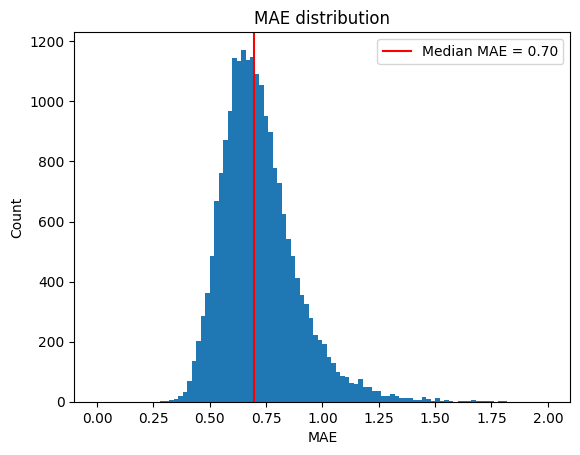

In [25]:
#Compute histogram of RMSEs
import matplotlib.pyplot as plt
plt.hist(list(errors.values()), bins = 100, range = (0,2))
#add median error
median_error = np.median(list(errors.values()))
plt.axvline(median_error, color = "red", label = f"Median MAE = {median_error:.2f}")
plt.legend()
plt.xlabel("MAE")
plt.ylabel("Count")
plt.title("MAE distribution")
#parent directory
plt.savefig("MAE.png", dpi = 600)
plt.show()

In [ ]:
#Compute similarity matrix
similarity_matrix = np.zeros((len(users), len(users)))
for i, user1 in tqdm(enumerate(users.values())):
    for j, user2 in enumerate(users.values()):
        if i < j:
            similarity_matrix[i,j] = user1.similarity(user2, method = "jaccard")
            similarity_matrix[j,i] = similarity_matrix[i,j]
        if i == j:
            similarity_matrix[i,j] = 1

22it [00:27,  1.26s/it]


KeyboardInterrupt: 